# MLS R-value Analysis using Generalized R Method

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Tuple, List
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

## Load MLS Data from CSV

In [ ]:
# If you are running this on Google Colab, uncomment the following line
# from google.colab import drive
# drive.mount('/content/drive')

# mls_raw = pd.read_csv('adjustpathhere/MLSmatches.csv')  # Adjust path as needed

# mls_raw.head()

Mounted at /content/drive


,id,home,away,date,year,time (utc),attendance,venue,league,part_of_competition,...,away_offsides,home_wonCorners,away_wonCorners,home_saves,away_saves,away_bench_14_num,away_bench_14,away_bench_14_minute,home_formation,away_formation
0,NaN,New England,San Jose,7/31/1996,1996,NaN,"12,871",Foxboro Stadium,1996 MLS,Regular Season,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Dallas,Colorado,6/15/1996,1996,NaN,"9,704",Cotton Bowl,1996 MLS,Regular Season,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Colorado,D.C. United,8/29/1996,1996,NaN,"6,368",Mile High Stadium,1996 MLS,Regular Season,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,LA Galaxy,New England,8/8/1996,1996,NaN,"10,251",Rose Bowl,1996 MLS,Regular Season,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,New England,D.C. United,7/20/1996,1996,NaN,"18,347",Foxboro Stadium,1996 MLS,Regular Season,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
mls_raw = pd.read_csv('/home/work/data/dataset/MHL/mat-hist/MLSmatches.csv')  # Adjust path as needed
mls_raw.head()

,id,home,away,date,year,time (utc),attendance,venue,league,part_of_competition,...,away_offsides,home_wonCorners,away_wonCorners,home_saves,away_saves,away_bench_14_num,away_bench_14,away_bench_14_minute,home_formation,away_formation
0,NaN,New England,San Jose,7/31/1996,1996,NaN,"12,871",Foxboro Stadium,1996 MLS,Regular Season,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Dallas,Colorado,6/15/1996,1996,NaN,"9,704",Cotton Bowl,1996 MLS,Regular Season,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Colorado,D.C. United,8/29/1996,1996,NaN,"6,368",Mile High Stadium,1996 MLS,Regular Season,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,LA Galaxy,New England,8/8/1996,1996,NaN,"10,251",Rose Bowl,1996 MLS,Regular Season,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,New England,D.C. United,7/20/1996,1996,NaN,"18,347",Foxboro Stadium,1996 MLS,Regular Season,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Preprocessing

Convert the Kaggle format to match the football-data.co.uk format that our existing code expects.

In [3]:
# Filter to regular season only (exclude playoffs)
mls_regular = mls_raw[mls_raw['part_of_competition'].str.contains('Regular Season', na=False)].copy()

print(f"Regular season matches: {len(mls_regular)}")
print(f"Playoff/other matches excluded: {len(mls_raw) - len(mls_regular)}")

# Convert date format - use flexible parsing that tries multiple formats
mls_regular['Date'] = pd.to_datetime(mls_regular['date'], errors='coerce', infer_datetime_format=True)

# Check how many dates are still missing
missing_dates = mls_regular['Date'].isnull().sum()
if missing_dates > 0:
    # Group by season and assign sequential dates
    for season in mls_regular[mls_regular['Date'].isnull()]['year'].unique():
        mask = (mls_regular['year'] == season) & (mls_regular['Date'].isnull())
        n_matches = mask.sum()
        # Assign sequential dates within that season
        mls_regular.loc[mask, 'Date'] = pd.date_range(
            start=f'{season}-03-01',
            periods=n_matches,
            freq='D'
        )
    print(f"✓ Assigned sequential dates to matches without dates")

# Rename columns to match football-data.co.uk format
mls_regular = mls_regular.rename(columns={
    'home': 'HomeTeam',
    'away': 'AwayTeam',
    'home_score': 'FTHG',
    'away_score': 'FTAG',
    'year': 'season'
})

# Now we can safely drop rows with missing scores
mls_regular = mls_regular.dropna(subset=['FTHG', 'FTAG'])

# Convert scores to integers
mls_regular['FTHG'] = mls_regular['FTHG'].astype(int)
mls_regular['FTAG'] = mls_regular['FTAG'].astype(int)

# Add division column
mls_regular['division'] = 'MLS'

mls_regular[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'season']].head()

Regular season matches: 6903
Playoff/other matches excluded: 386
✓ Assigned sequential dates to matches without dates


,Date,HomeTeam,AwayTeam,FTHG,FTAG,season
0,1996-07-31,New England,San Jose,2,0,1996
1,1996-06-15,Dallas,Colorado,1,1,1996
2,1996-08-29,Colorado,D.C. United,1,2,1996
3,1996-08-08,LA Galaxy,New England,1,0,1996
4,1996-07-20,New England,D.C. United,2,0,1996


In [4]:
mls_regular.groupby('season').size()

season
1996    160
1997    160
1998    192
1999    192
2000    192
2001    158
2002    140
2003    150
2004    146
2005    191
2006    191
2007    195
2008    211
2009    225
2010    240
2011    306
2012    323
2013    323
2014    323
2015    340
2016    340
2017    374
2018    391
2019    408
2020    292
2021    459
2022    281
dtype: int64

## Organize Data into Dictionary Structure


In [5]:
# Standardize team names across all seasons
team_name_mapping = {
    # Chicago
    'Chicago Fire FC': 'Chicago',
    'Chicago Fire': 'Chicago',
    # Colorado
    'Colorado Rapids': 'Colorado',
    # Columbus
    'Columbus Crew SC': 'Columbus',
    'Columbus Crew': 'Columbus',
    # Dallas
    'FC Dallas': 'Dallas',
    # DC
    'DC United': 'D.C. United',
    # Kansas City
    'Sporting Kansas City': 'KC Wiz',
    'KC Wizards': 'KC Wiz',
    'Kansas City': 'KC Wiz',
    # LA
    'LA Galaxy': 'LA Galaxy',
    # New England
    'New England Revolution': 'New England',
    # New York
    'New York Red Bulls': 'MetroStars',
    'NY Red Bulls': 'MetroStars',
    # San Jose
    'San Jose Earthquakes': 'San Jose',
}

# Apply mapping
mls_regular['HomeTeam'] = mls_regular['HomeTeam'].replace(team_name_mapping)
mls_regular['AwayTeam'] = mls_regular['AwayTeam'].replace(team_name_mapping)

# Check unique team names after standardization
all_teams = sorted(set(mls_regular['HomeTeam']).union(set(mls_regular['AwayTeam'])))
print(f"Standardized team names ({len(all_teams)} unique teams):")
print(all_teams)

Standardized team names (33 unique teams):
['Atlanta United FC', 'Austin FC', 'CF Montréal', 'Charlotte FC', 'Chicago', 'Chivas USA', 'Colorado', 'Columbus', 'D.C. United', 'Dallas', 'FC Cincinnati', 'Houston Dynamo', 'Houston Dynamo FC', 'Inter Miami CF', 'KC Wiz', 'LA Galaxy', 'LAFC', 'MetroStars', 'Miami', 'Minnesota United FC', 'Montreal Impact', 'Nashville SC', 'New England', 'New York City FC', 'Orlando City SC', 'Philadelphia Union', 'Portland Timbers', 'Real Salt Lake', 'San Jose', 'Seattle Sounders FC', 'Tampa Bay', 'Toronto FC', 'Vancouver Whitecaps']


In [6]:
# Organize by season
data_dict_mls = {}

for season in mls_regular['season'].unique():
    season_data = mls_regular[mls_regular['season'] == season].copy()
    data_dict_mls[str(season)] = {'MLS': season_data}

for season in sorted(data_dict_mls.keys()):
    n_matches = len(data_dict_mls[season]['MLS'])
    n_teams = len(set(data_dict_mls[season]['MLS']['HomeTeam']).union(
                     set(data_dict_mls[season]['MLS']['AwayTeam'])))

## Helper Functions

In [7]:
def _ensure_datetime(df: pd.DataFrame):
    """Ensure Date column is datetime type"""
    if not np.issubdtype(df["Date"].dtype, np.datetime64):
        df = df.copy()
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    return df


def _team_rows(df: pd.DataFrame, team: str) -> pd.DataFrame:
    """Build per-team match list with perspective columns"""
    home = df[df["HomeTeam"] == team].copy()
    away = df[df["AwayTeam"] == team].copy()

    home["gf"] = home["FTHG"]
    home["ga"] = home["FTAG"]
    home["venue"] = "H"
    away["gf"] = away["FTAG"]
    away["ga"] = away["FTHG"]
    away["venue"] = "A"

    # Points and outcomes
    goal_diff = home["gf"] - home["ga"]
    home["win"] = (goal_diff > 0).astype(int)
    home["draw"] = (goal_diff == 0).astype(int)
    home["loss"] = (goal_diff < 0).astype(int)
    home["pts"] = home["win"] * 3 + home["draw"] * 1

    goal_diff = away["gf"] - away["ga"]
    away["win"] = (goal_diff > 0).astype(int)
    away["draw"] = (goal_diff == 0).astype(int)
    away["loss"] = (goal_diff < 0).astype(int)
    away["pts"] = away["win"] * 3 + away["draw"] * 1

    # Unify
    cols = ["Date", "venue", "gf", "ga", "win", "draw", "loss", "pts", "HomeElo", "AwayElo"]
    home_part = home[cols]
    away_part = away[cols]
    t = pd.concat([home_part, away_part], ignore_index=True)
    t = t.sort_values("Date")
    return t

## Elo Rating System

In [8]:
def update_elo(R_i, R_j, outcome_i, K=20, H=0):
    """Update Elo ratings after a single match"""
    E_i = 1.0 / (1 + 10 ** ((R_j - R_i + H) / 400))
    E_j = 1.0 - E_i
    R_i_new = R_i + K * (outcome_i - E_i)
    R_j_new = R_j + K * ((1 - outcome_i) - E_j)
    return R_i_new, R_j_new


def compute_elo_ratings(df, base_rating=1500, K=20):
    """Compute Elo ratings for all teams, tracking pre-match ratings"""
    teams = sorted(set(df["HomeTeam"]).union(set(df["AwayTeam"])))
    ratings = {t: base_rating for t in teams}
    pre_elos = []

    for _, row in df.sort_values("Date").iterrows():
        ht, at = row["HomeTeam"], row["AwayTeam"]
        hg, ag = row["FTHG"], row["FTAG"]

        if hg > ag:
            outcome_h = 1.0
        elif hg == ag:
            outcome_h = 0.5
        else:
            outcome_h = 0.0

        R_h, R_a = ratings[ht], ratings[at]
        pre_elos.append({
            "Date": row["Date"],
            "HomeTeam": ht,
            "AwayTeam": at,
            "HomeElo": R_h,
            "AwayElo": R_a
        })

        new_R_h, new_R_a = update_elo(R_h, R_a, outcome_h, K=K)
        ratings[ht], ratings[at] = new_R_h, new_R_a

    pre_df = pd.DataFrame(pre_elos)
    df = df.merge(pre_df, on=["Date", "HomeTeam", "AwayTeam"], how="left")
    return df

## Stratified Splitting Functions (Generalized R Method)

In [9]:
def stratified_split(team_df, rng, eps=0.05, metric_mode="ppg"):
    """
    Split team matches into two folds (A, B) balanced by opponent Elo.
    Uses stratification with random tie-breaking.
    """
    matches = team_df.copy()
    matches = matches.sort_values("Date")

    # Get opponent Elo ratings
    opp_elos = []
    for _, row in matches.iterrows():
        if row["venue"] == "H":
            opp_elos.append(row["AwayElo"])
        else:
            opp_elos.append(row["HomeElo"])
    matches["opp_elo"] = opp_elos

    # Bin by Elo quartiles
    bins = pd.qcut(matches["opp_elo"], q=min(5, len(matches)), duplicates="drop")
    matches["elo_bin"] = bins

    A_idx, B_idx = [], []
    for _, g in matches.groupby("elo_bin"):
        idxs = g.index.tolist()
        rng.shuffle(idxs)
        half = len(idxs) // 2
        A_idx.extend(idxs[:half])
        B_idx.extend(idxs[half:])

    A = matches.loc[A_idx]
    B = matches.loc[B_idx]

    return A, B


def performance_metric(fold_df, metric_mode="ppg"):
    """Calculate performance metric for a fold"""
    if len(fold_df) == 0:
        return np.nan
    if metric_mode == "ppg":
        pts = fold_df["pts"].sum()
        return (pts / len(fold_df)) / 3.0
    elif metric_mode == "winfrac":
        wins = fold_df["win"].sum()
        return wins / len(fold_df)
    else:
        raise ValueError("metric_mode must be 'ppg' or 'winfrac'")


## Generalized R Computation

In [10]:
def compute_generalized_R(data_dict, metric_mode="ppg", K=200, seed=123):
    """
    Compute Generalized R-value using stratified splitting.

    Parameters:
    - data_dict: nested dict {season: {division: DataFrame}}
    - metric_mode: 'ppg' (points per game) or 'winfrac' (win fraction)
    - K: number of random splits per team
    - seed: random seed for reproducibility
    """
    rng = np.random.default_rng(seed)
    rows = []

    for season, divmap in data_dict.items():
        for division, df in divmap.items():
            # Compute Elo ratings
            df = compute_elo_ratings(df)

            teams = sorted(set(df["HomeTeam"]).union(set(df["AwayTeam"])))
            XY_all = []

            for team in teams:
                trows = _team_rows(df, team)
                if len(trows) < 4:
                    continue

                # K random splits per team
                for k in range(K):
                    A, B = stratified_split(trows, rng, metric_mode=metric_mode)
                    x = performance_metric(A, metric_mode)
                    y = performance_metric(B, metric_mode)
                    if np.isfinite(x) and np.isfinite(y):
                        XY_all.append((x, y))

            if len(XY_all) >= 3:
                X = np.array([u for u, v in XY_all])
                Y = np.array([v for u, v in XY_all])
                S = (X + Y) / np.sqrt(2)
                T = (Y - X) / np.sqrt(2)
                A_var = np.var(S, ddof=0)
                B_var = np.var(T, ddof=0)
                R = 1 - B_var / A_var if A_var > 1e-12 else np.nan
                rows.append({
                    "division": division,
                    "season": season,
                    "metric_mode": metric_mode,
                    "teams": len(teams),
                    "R": R
                })

    return pd.DataFrame(rows)


## Run the Analysis

In [13]:
# Compute with K=200 splits (as in original paper)
gen_r_mls = compute_generalized_R(data_dict_mls, metric_mode='ppg', K=200)

print("\nMLS Generalized R-values:")
print(gen_r_mls.to_string(index=False))


MLS Generalized R-values:
division season metric_mode  teams         R
     MLS   1996         ppg     10  0.016241
     MLS   1997         ppg     10 -0.383757
     MLS   1998         ppg     12  0.566246
     MLS   1999         ppg     12  0.733043
     MLS   2000         ppg     12  0.254536
     MLS   2001         ppg     12  0.692164
     MLS   2002         ppg     10 -1.029782
     MLS   2003         ppg     10  0.205868
     MLS   2004         ppg     10 -0.912589
     MLS   2005         ppg     12  0.685195
     MLS   2006         ppg     12 -0.417461
     MLS   2007         ppg     13  0.390842
     MLS   2008         ppg     14 -0.208280
     MLS   2009         ppg     15  0.102327
     MLS   2010         ppg     16  0.528127
     MLS   2011         ppg     18  0.505376
     MLS   2012         ppg     19  0.614137
     MLS   2013         ppg     19  0.544991
     MLS   2014         ppg     19  0.505964
     MLS   2015         ppg     20 -0.037566
     MLS   2016         ppg 

## Summary Statistics

In [14]:
print(f"Mean R-value: {gen_r_mls['R'].mean():.3f}")
print(f"Median R-value: {gen_r_mls['R'].median():.3f}")
print(f"Std Dev: {gen_r_mls['R'].std():.3f}")
print(f"Min: {gen_r_mls['R'].min():.3f}")
print(f"Max: {gen_r_mls['R'].max():.3f}")
print("\nR-values by season:")
print(gen_r_mls[['season', 'teams', 'R']].sort_values('season').to_string(index=False))

Mean R-value: 0.216
Median R-value: 0.391
Std Dev: 0.470
Min: -1.030
Max: 0.733

R-values by season:
season  teams         R
  1996     10  0.016241
  1997     10 -0.383757
  1998     12  0.566246
  1999     12  0.733043
  2000     12  0.254536
  2001     12  0.692164
  2002     10 -1.029782
  2003     10  0.205868
  2004     10 -0.912589
  2005     12  0.685195
  2006     12 -0.417461
  2007     13  0.390842
  2008     14 -0.208280
  2009     15  0.102327
  2010     16  0.528127
  2011     18  0.505376
  2012     19  0.614137
  2013     19  0.544991
  2014     19  0.505964
  2015     20 -0.037566
  2016     20  0.118117
  2017     22  0.292662
  2018     23  0.633122
  2019     24  0.406718
  2020     26  0.488611
  2021     27  0.537706
  2022     28  0.008956


## Visualization Functions

In [20]:
def plot_mls_R_boxplot(df: pd.DataFrame):
    """Create boxplot visualization for MLS R-values"""
    plt.figure(figsize=(10, 4))

    data = [df["R"].dropna().values]

    bp = plt.boxplot(data, vert=False, labels=["MLS"],
                     manage_ticks=True, whis=[5, 95], showmeans=True)

    # Overlay individual season points
    vals = df["R"].dropna().values
    y = np.full_like(vals, 1.0, dtype=float) + (np.random.rand(len(vals)) - 0.5) * 0.06
    plt.plot(vals, y, "o", markersize=6, alpha=0.7)

    plt.xlabel("R (within-season persistence; Generalized R)")
    plt.title("MLS R-value Distribution (Regular Season Only)")
    plt.xlim(-1, 1)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_mls_trend(df: pd.DataFrame, data_dict: Dict = None):
    """Plot R-value trend over seasons with match counts"""
    fig, ax1 = plt.subplots(figsize=(12, 5))

    df_sorted = df.sort_values('season')

    # Plot R-value on left y-axis
    ax1.plot(df_sorted['season'].astype(str), df_sorted['R'], 'o-', linewidth=2, markersize=8, color='blue', label='R-value')
    ax1.set_xlabel("Season")
    ax1.set_ylabel("R-value", color='blue')
    ax1.set_ylim(-1, 1)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(alpha=0.3)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

    # Calculate match counts if not in dataframe
    if 'matches' not in df_sorted.columns:
        if data_dict is not None:
            matches = []
            for season in df_sorted['season']:
                n_matches = len(data_dict[str(season)]['MLS'])
                matches.append(n_matches)
            df_sorted = df_sorted.copy()
            df_sorted['matches'] = matches
        else:
            # If no data_dict provided and no matches column, skip match count display
            fig.suptitle("MLS R-value Trend Over Time (1996-Present)")
            fig.tight_layout()
            plt.show()
            return

    # Plot match counts on right y-axis
    ax2 = ax1.twinx()
    ax2.bar(df_sorted['season'].astype(str), df_sorted['matches'], alpha=0.3, color='orange', label='# of matches')
    ax2.set_ylabel("# of matches", color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    fig.suptitle("MLS R-value Trend Over Time (1996-Present)")
    fig.tight_layout()
    plt.show()

## Generate Visualizations

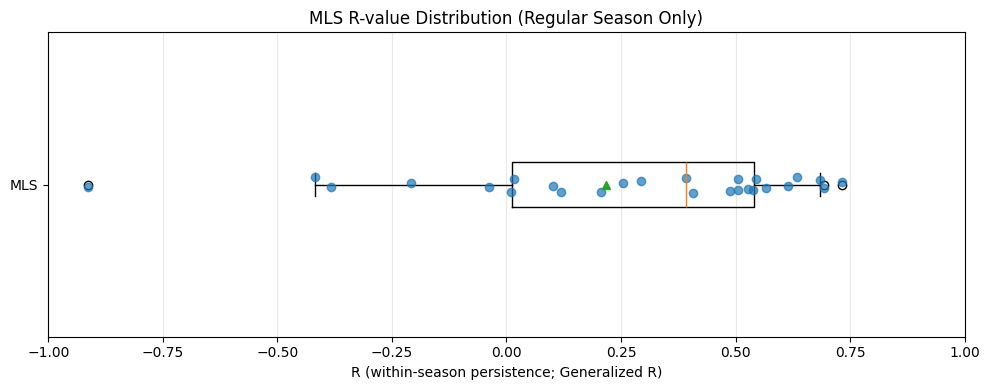

In [35]:
plot_mls_R_boxplot(gen_r_mls)

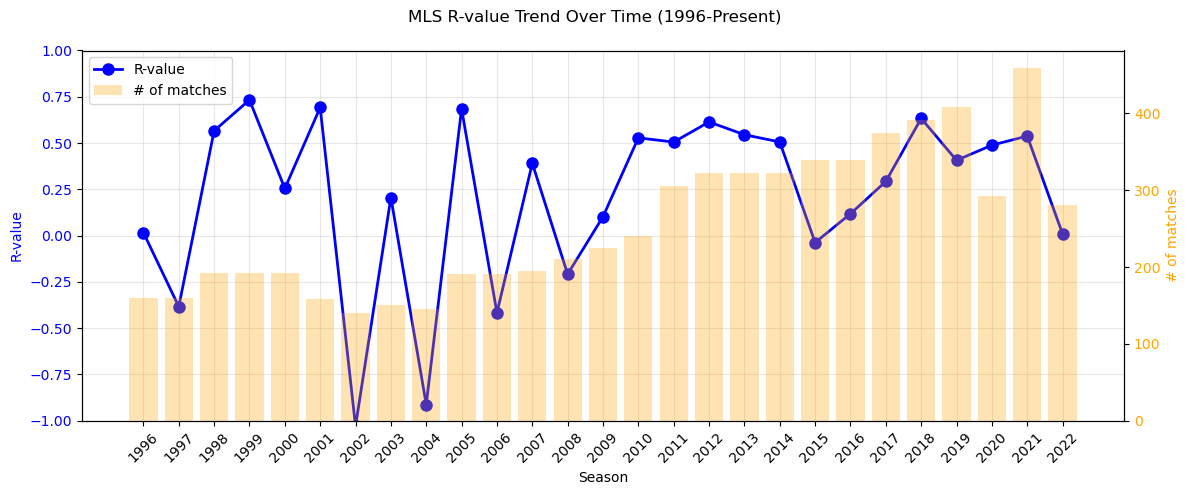

In [21]:
plot_mls_trend(gen_r_mls, data_dict_mls)

## Save Results

In [37]:
# Save to CSV
output_file = "mls_r_values.csv"
gen_r_mls.to_csv(output_file, index=False)
print(f"✓ Results saved to: {output_file}")

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)

✓ Results saved to: mls_r_values.csv

ANALYSIS COMPLETE


In [40]:
gen_r_mls_export = gen_r_mls.copy()
gen_r_mls_export['league_group'] = 'MLS'

matches_per_season = []
for season in gen_r_mls_export['season']:
    n_matches = len(data_dict_mls[str(season)]['MLS'])
    matches_per_season.append(n_matches)

gen_r_mls_export['matches'] = matches_per_season

print(gen_r_mls_export[['division', 'season', 'teams', 'matches', 'R', 'league_group']].head(30))

gen_r_mls_export.to_csv("mls_r_values_for_combined_analysis.csv", index=False)
print("\n✓ Export file saved: mls_r_values_for_combined_analysis.csv")

MLS data ready for combination with Big 5 leagues:
   division season  teams  matches         R league_group
0       MLS   1996     10      160  0.016241          MLS
1       MLS   1997     10      160 -0.383757          MLS
2       MLS   1998     12      192  0.566246          MLS
3       MLS   1999     12      192  0.733043          MLS
4       MLS   2000     12      192  0.254536          MLS
5       MLS   2001     12      158  0.692164          MLS
6       MLS   2002     10      140 -1.029782          MLS
7       MLS   2003     10      150  0.205868          MLS
8       MLS   2004     10      146 -0.912589          MLS
9       MLS   2005     12      191  0.685195          MLS
10      MLS   2006     12      191 -0.417461          MLS
11      MLS   2007     13      195  0.390842          MLS
12      MLS   2008     14      211 -0.208280          MLS
13      MLS   2009     15      225  0.102327          MLS
14      MLS   2010     16      240  0.528127          MLS
15      MLS   2011   